# CBU5201 miniproject basic task



## 1 Author

**Student Name**: Chenhui Qiu

**QMID**: 210981508

## 2 Problem formulation

#### 2.1 Smile Detection (Task 1)
In Task 1, the objective is to develop a machine learning model capable of detecting smiles in images.  Smile detection has practical applications in areas like emotion recognition, human-computer interaction, and even in enhancing customer experiences in various service industries. 

#### 2.2 Head Pose Estimation (Task 2)
Task 2 focuses on estimating the head pose of individuals in images, specifically by determining three angles: yaw, pitch, and roll. This problem is significant in fields such as augmented reality, driver monitoring systems, and facial recognition technologies. 


## 3 Machine Learning Pipeline

Our project's Machine Learning pipeline is designed to handle two interconnected tasks: Smile Detection and Head Pose Estimation, both utilizing the Genki4K dataset. Here's a unified overview of the pipeline stages for these tasks:

### 1. Input

The input stage involves sourcing a diverse collection of facial images from the Genki4K dataset. These images encompass a wide range of facial expressions and orientations, providing a rich dataset for our tasks.

### 2. Preprocessing

- **Face Detection**: Each image undergoes preprocessing using the Multi-task Cascaded Convolutional Networks (MTCNN). This process involves detecting faces within the images and cropping to focus on the facial regions.
- **Normalization**: The cropped facial images are resized and normalized to ensure uniformity and compatibility with the neural network models.

### 3. Model Training

- **Smile Detection**: For detecting smiles, we adapt the ResNet-18 model for binary classification. This model learns to differentiate between smiling and non-smiling faces.
- **Head Pose Estimation**: The same ResNet-18 architecture, with slight modifications, is used for predicting head pose. It estimates three continuous values: yaw, pitch, and roll angles, representing the head's orientation.

### 4. Evaluation

- **Smile Detection**: We assess the model's accuracy in identifying smiles. This involves testing the model on a separate set of images and calculating the percentage of correctly identified smiles.
- **Head Pose Estimation**: The model's precision in estimating head poses is evaluated using Mean Squared Error (MSE), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) metrics. These metrics quantify the model's performance in accurately predicting head orientations.

If finding that the effect is not good or overfitting occurs during the verification phase, we need to make certain adjustments to the hyperparameters of the model and loss function, and test multiple algorithms and models if possible, and return to the training phase. continue to optimize.

### 5. Output

- **Smile Detection Model**: Capable of accurately distinguishing smiles in various facial images.
- **Head Pose Estimation Model**: Efficient in predicting the orientation of a head in terms of yaw, pitch, and roll angles.

## 4 Dataset


The primary dataset used in this project is the "Genki4K," a comprehensive collection of facial images. This dataset is known for its diversity in facial expressions and orientations.

### Preprocessing with MTCNN

- **Why MTCNN**: MTCNN (Multi-task Cascaded Convolutional Networks) is a highly effective method for face detection, particularly adept at handling different scales of faces within images. It's chosen for its accuracy in isolating faces from complex backgrounds , which is critical for consistent model training.
- **Process**: MTCNN detects facial landmarks (like eyes, nose, and mouth) and crops the faces. This step ensures that the models focus on relevant facial features without background distractions.
- **Outcome**: Post MTCNN processing, images are saved in the `processed_files` directory, providing a clean, uniform set of images for further processing.



In [193]:
import os
import torch
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
from PIL import Image
from facenet_pytorch import MTCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize MTCNN
mtcnn = MTCNN(keep_all=False, device=device, image_size=128, margin=30)
original_img_dir = 'genki4k/files'  
processed_img_dir = 'genki4k/processed_files'  

# create processed image dir
if not os.path.exists(processed_img_dir):
    os.makedirs(processed_img_dir)


processed_images = []

for img_file in tqdm(os.listdir(original_img_dir), desc="Processing Images"):
    img_path = os.path.join(original_img_dir, img_file)
    img = Image.open(img_path).convert('RGB')
    img_cropped = mtcnn(img)
    if img_cropped is not None:
        img_cropped_pil = to_pil_image(img_cropped)  
        processed_img_path = os.path.join(processed_img_dir, img_file)
        img_cropped_pil.save(processed_img_path)  
        processed_images.append(img_file)


Processing Images: 100%|██████████| 4000/4000 [01:37<00:00, 41.06it/s]


## 5 Transformation Stage

 This stage involves adapting the input data to a format suitable for efficient processing by deep learning models.

### Input

The input to this stage comprises face images, which have already been pre-processed using the MTCNN. 

### Output

The output of the transformation stage is a set of tensorized and normalized images. These tensors are ready for consumption by the deep learning models, enabling them to learn from the data efficiently.

### Process and Rationale

1. **Tensor Transformation**: Each image is converted into a tensor, which is the standard format for images in PyTorch-based deep learning models. This transformation facilitates efficient computation and is particularly suitable for GPU-based training.

2. **Normalization**: The images are normalized using the mean and standard deviation of the ImageNet dataset. This step is crucial for models pre-trained on ImageNet, as it aligns the new input data with the data distribution seen during the model's initial training. After many standardized parameter adjustments, these parameters in the code were selected. Normalization ensures consistent scale and variance, leading to better model performance and faster convergence during training.

**More importantly, after testing, it was found that the values and changes of the three amplitude parameters in Task 2 were small. In order to prevent the gradient descent from being too difficult, the three labels were enlarged ten times, so in the curve The loss will appear higher on the graph, two orders of magnitude higher than the normal loss. The indicators will be restored during the evaluation phase.**

In [194]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.dataloader import default_collate

# dataset for Task1
class MyDataset_T1(Dataset):
    def __init__(self, processed_img_dir, label_file, transform=None):
        self.img_dir = processed_img_dir
        self.transform = transform
        self.labels = []
        with open(label_file, 'r') as f:
            for line in f:
                line = line.strip().split()
                img_name = f"file{int(line[0])+1:04d}.jpg"
                if img_name in processed_images:
                    self.labels.append(line)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = f'file{idx+1:04d}.jpg'
        img_path = os.path.join(self.img_dir, img_name)

        if not os.path.exists(img_path):
            return None

        image = Image.open(img_path) 

        if self.transform:
            image = self.transform(image)

        smile_label, yaw, pitch, roll = self.labels[idx]
        return image, torch.tensor(int(smile_label), dtype=torch.float32)

# dataset for Task2
class MyDataset_T2(Dataset):
    def __init__(self, processed_img_dir, label_file, transform=None):
        self.img_dir = processed_img_dir
        self.transform = transform
        self.labels = []
        with open(label_file, 'r') as f:
            for line in f:
                line = line.strip().split()
                img_name = f"file{int(line[0])+1:04d}.jpg"
                if img_name in processed_images:
                    self.labels.append(line)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = f'file{idx+1:04d}.jpg'
        img_path = os.path.join(self.img_dir, img_name)

        if not os.path.exists(img_path):
            return None

        image = Image.open(img_path)  

        if self.transform:
            image = self.transform(image)

        smile_label, yaw, pitch, roll = self.labels[idx]
        pose_label = torch.tensor([float(yaw)*10, float(pitch)*10, float(roll)*10], dtype=torch.float32)
        return image, pose_label

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.Tensor(), torch.Tensor()
    return default_collate(batch)
 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



## 6 Modelling

 We propose a unified approach using a single model architecture, the ResNet-18, to address both tasks efficiently. The ResNet-18 model is selected for its balance between performance and computational efficiency.

The core of our approach is a ResNet-18 model, a deep convolutional neural network known for its effectiveness in image classification tasks. The model is pre-trained on the ImageNet dataset, allowing us to leverage a rich feature representation learned from a vast and diverse set of images.

**After multiple tests, it was found that the effect of this model with pre-trained weights was significantly higher than that without. However, using a model with pre-trained weights will lead to a rapid entry into the optimal phase leading to a certain degree of overfitting. After a trade-off, it is still chosen to use a model with pre-trained weights to achieve higher accuracy.**

- **Smile Detection**: For the smile detection task, which is a binary classification problem, the model's final fully connected layer will be adjusted to output a single neuron with a sigmoid activation function. This output represents the probability of the presence of a smile in the image.
- **Head Pose Estimation**: In parallel, for the head pose estimation task, the same model will be employed to predict the continuous values of yaw, pitch, and roll angles. This requires modifying the final layer to output three neurons, each representing one of these angles.



In [195]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
pre_fc_in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(pre_fc_in_features, 512),
    nn.GELU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1)
)
model = model.to(device)  

model2 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
pre_fc_in_features2 = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(pre_fc_in_features2, 512),
    nn.GELU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)  # output yaw, pitch, roll
)
model2 = model2.to(device)


## 7 Methodology

### Training Strategy for Task 1 (Smile Detection)

1. **Loss Function**: Binary Cross-Entropy Loss is used, suitable for the binary nature of smile detection.

2. **Optimizer**: Adam optimizer with an initial learning rate of 0.0014, The L2 regularization parameter is 1e-5.

3. **Scheduler**: Learning rate is reduced by 25% every 3 epochs to refine learning.

### Training Strategy for Task 2 (Head Pose Estimation)

1. **Loss Function**: Mean Squared Error (MSE) Loss quantifies the error in angle prediction.

2. **Optimizer**: Adam optimizer with an initial learning rate of 0.001, The L2 regularization parameter is 1e-5.

### Evaluation During Training

1. **Dataset Split**: The dataset is divided into training, validation, and testing sets, following a 70%-15%-15% split. This division allows for robust training and fair evaluation.

2. **Model Validation**: During the training phase, the model's performance is validated after each epoch using the validation set. This step is crucial to monitor the model’s learning and to make adjustments to prevent overfitting.

3. **Performance Metrics**: 
   - For smile detection, we primarily focus on accuracy and periodically check the confusion matrix.
   - For head pose estimation, we evaluate the training progress using Mean Squared Error (MSE).

4. **Visualization**: Training and validation loss graphs are plotted to assess learning progression.


In [196]:
# load dataset
dataset_T1 = MyDataset_T1(processed_img_dir='genki4k/processed_files', 
                    label_file='genki4k/labels.txt', 
                    transform=transform)

dataset_T2 = MyDataset_T2(processed_img_dir='genki4k/processed_files', 
                    label_file='genki4k/labels.txt', 
                    transform=transform)

# divide the dataset
train_size = int(0.8 * len(dataset_T1))
valid_size = int(0.1 * len(dataset_T1))
test_size = len(dataset_T1) - train_size - valid_size

train_dataset_T1, valid_dataset_T1, test_dataset_T1 = random_split(dataset_T1, [train_size, valid_size, test_size])
train_dataset_T2, valid_dataset_T2, test_dataset_T2 = random_split(dataset_T2, [train_size, valid_size, test_size])

# DataLoader and batch size
batch_size = 256  
train_loader_T1 = DataLoader(train_dataset_T1, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader_T1 = DataLoader(valid_dataset_T1, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader_T1 = DataLoader(test_dataset_T1, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

train_loader_T2 = DataLoader(train_dataset_T2, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader_T2 = DataLoader(valid_dataset_T2, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader_T2 = DataLoader(test_dataset_T2, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

criterion_T1 = torch.nn.BCEWithLogitsLoss() 
optimizer_T1 = torch.optim.Adam(model.parameters(), lr=0.0014,  weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_T1, step_size=3, gamma=0.75)

criterion_T2 = torch.nn.MSELoss()  
optimizer_T2 = torch.optim.Adam(model2.parameters(), lr=0.001,  weight_decay=1e-5)



## 8. Results

### Task 1: Smile Detection

The smile detection model underwent a comprehensive training for 20 epochs. The training commenced with a loss of 0.607 and remarkably reduced to a minuscule 0.000156 by the end. This sharp decline signifies the model’s increasing proficiency in identifying smiling faces. The validation loss exhibited fluctuations, peaking initially at 1.34 and eventually steadying. This behavior suggested an initial tendency towards overfitting, which was later corrected as the model learned to generalize better.

The model's efficacy was most pronounced in the testing phase, where it achieved an accuracy of 94%. The test loss stood at 0.3988 with the high accuracy. The normalized confusion matrix further display the model's competence, displaying a substantial number of true positives and negatives, indicating accurate classifications.

### Task 2: Head Pose Estimation

**Note that due to the amplification of labels here, the loss on the line chart is two orders of magnitude higher than in the test stage.**

For head pose estimation, the model was also trained  20 epochs. Training loss showed a downward trend from 1.98 to 0.122, and validation loss improved from 7.59 to 0.563, suggesting progressive learning. Notably, the validation loss was initially high due to the amplification of labels, but it adjusted over time, reflecting the model’s adaptation.

The testing phase yielded encouraging results with a Mean Squared Error (MSE) of 0.006310, a Mean Absolute Error (MAE) of 0.056345, and a Root Mean Squared Error (RMSE) of 0.079433. These metrics collectively indicate the model's precision in estimating head poses, with small deviation from the actual values.




---------------------T1 TRAIN START--------------------


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.32it/s, Validation Loss=1.34]


Accuracy: 0.80


Validating: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s, Validation Loss=0.537]


Accuracy: 0.88


Validating: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s, Validation Loss=0.218]


Accuracy: 0.93


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s, Validation Loss=0.227]


Accuracy: 0.92


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.08it/s, Validation Loss=0.402]


Accuracy: 0.90


Validating: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s, Validation Loss=0.363]


Accuracy: 0.90


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s, Validation Loss=0.284]


Accuracy: 0.92


Validating: 100%|██████████| 2/2 [00:00<00:00,  5.59it/s, Validation Loss=0.421]


Accuracy: 0.89


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.26it/s, Validation Loss=0.341]


Accuracy: 0.93


Validating: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s, Validation Loss=0.368]


Accuracy: 0.90


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.20it/s, Validation Loss=0.316]


Accuracy: 0.93


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.25it/s, Validation Loss=0.337]


Accuracy: 0.92


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.12it/s, Validation Loss=0.359]


Accuracy: 0.92


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.13it/s, Validation Loss=0.345]


Accuracy: 0.92


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s, Validation Loss=0.345]


Accuracy: 0.92


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.25it/s, Validation Loss=0.347]


Accuracy: 0.92


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.28it/s, Validation Loss=0.349]


Accuracy: 0.92


Validating: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s, Validation Loss=0.352]


Accuracy: 0.92


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s, Validation Loss=0.353]


Accuracy: 0.92


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.24it/s, Validation Loss=0.355]


Accuracy: 0.93
---------------------TRAIN OVER--------------------


Testing: 100%|██████████| 2/2 [00:00<00:00,  6.01it/s, Test Loss=0.399]


Test Loss: 0.3988, Test Accuracy: 0.94


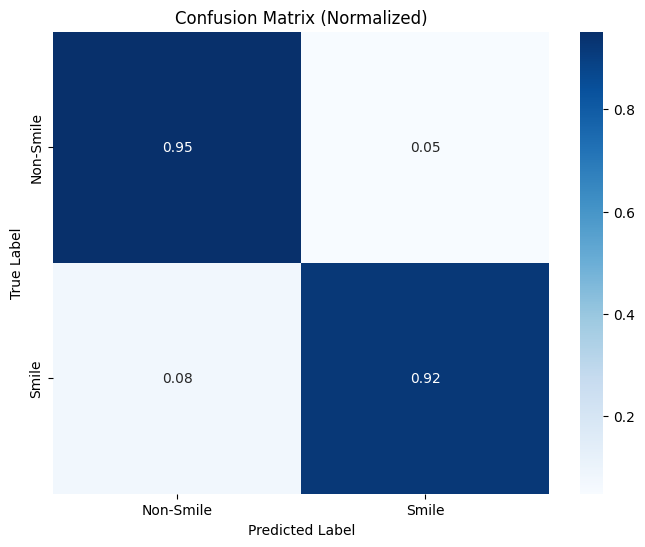

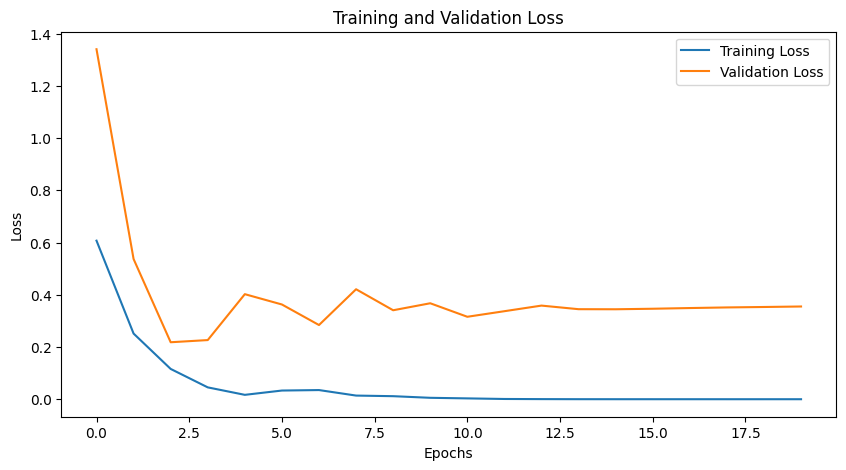

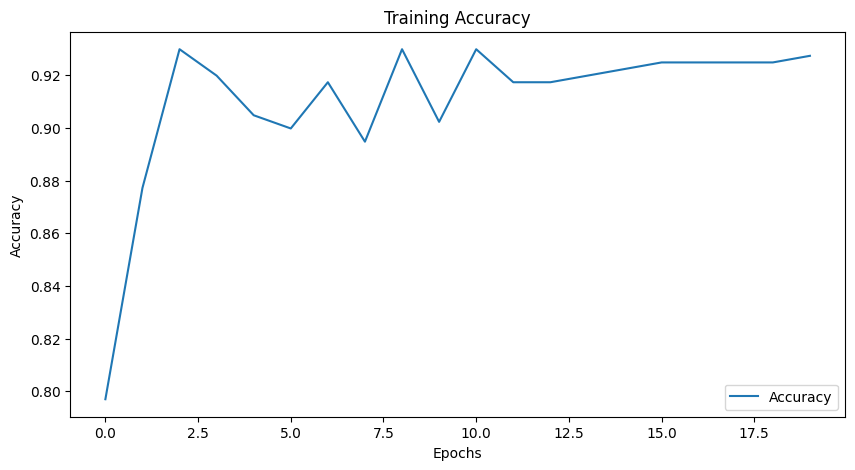

---------------------T2 TRAIN START--------------------


Validating: 100%|██████████| 2/2 [00:00<00:00,  6.07it/s, Validation Loss=0.563]


---------------------TRAIN OVER--------------------


Testing: 100%|██████████| 2/2 [00:00<00:00,  6.09it/s, Test Loss=0.646]


Test Loss: 0.64632732, MSE: 0.006310, MAE: 0.056345, RMSE: 0.079433


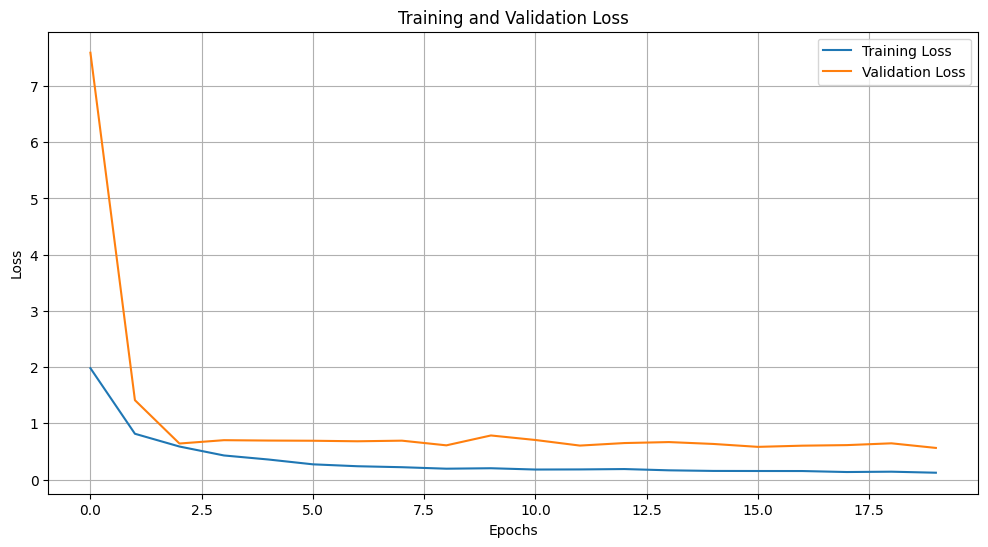

In [197]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

train_losses_T1 = []
valid_losses_T1 = []
accuracies = []

print(f'---------------------T1 TRAIN START--------------------')
num_epochs = 20  
for epoch in range(num_epochs):
    model.train()  # train model
    train_loss = 0.0
    progress_bar = tqdm(train_loader_T1, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for batch in progress_bar:
        if batch is None or batch[0] is None:
            continue  
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_T1.zero_grad()
        outputs = model(imgs).squeeze(1)
        loss = criterion_T1(outputs, labels)
        loss.backward()
        optimizer_T1.step()
        train_loss += loss.item()
        progress_bar.set_postfix({'Train Loss': train_loss / (progress_bar.n + 1)})
    train_loss /= len(train_loader_T1)
    train_losses_T1.append(train_loss)
    scheduler.step()



# valid the model
    model.eval()  
    valid_loss = 0.0
    correct_smiles = 0
    total_smiles = 0
    with tqdm(valid_loader_T1, desc='Validating') as progress_bar:
        for batch in progress_bar:
            if batch is None or batch[0] is None:
                continue  
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(imgs).squeeze(1)
                loss = criterion_T1(outputs, labels)
                valid_loss += loss.item()
                predicted_smiles = torch.sigmoid(outputs) > 0.5
                correct_smiles += (predicted_smiles == labels.bool()).sum().item()
                total_smiles += labels.size(0)
                progress_bar.set_postfix({'Validation Loss': valid_loss / (progress_bar.n + 1)})
    valid_loss /= len(valid_loader_T1)
    accuracy = correct_smiles / total_smiles
    valid_losses_T1.append(valid_loss)
    accuracies.append(accuracy)

    print(f'Accuracy: {accuracy:.2f}')

# save the model parameters
torch.save(model.state_dict(), 'model_smile.pth')
print(f'---------------------TRAIN OVER--------------------')

# test model
def test_model(model, test_loader, device, criterion):
    model.eval() 
    test_loss = 0.0
    correct_smiles = 0
    total_smiles = 0
    all_labels = []
    all_predictions = []
    
    with tqdm(test_loader, desc='Testing') as progress_bar:
        for batch in progress_bar:
            if batch is None or batch[0] is None:
                continue  
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(imgs).squeeze(1)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                predicted_smiles = torch.sigmoid(outputs) > 0.5
                correct_smiles += (predicted_smiles == labels.bool()).sum().item()
                total_smiles += labels.size(0)
                
                all_labels.extend(labels.cpu().tolist())
                all_predictions.extend(predicted_smiles.cpu().tolist())
                
                progress_bar.set_postfix({'Test Loss': test_loss / (progress_bar.n + 1)})
    
    test_loss /= len(test_loader)
    accuracy = correct_smiles / total_smiles
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}')
    
    cm = confusion_matrix(all_labels, all_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # draw confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Non-Smile', 'Smile'], yticklabels=['Non-Smile', 'Smile'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix (Normalized)')
    plt.savefig('confusion_matrix.png')
    plt.show()

    return accuracy, test_loss

test_model(model, test_loader_T1, device, criterion_T1)

# draw train loss and valid loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses_T1, label='Training Loss')
plt.plot(valid_losses_T1, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot_T1.png')  
plt.show()

# draw accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot_T1.png') 
plt.show()


train_losses_T2 = []
valid_losses_T2 = []

# train
print(f'---------------------T2 TRAIN START--------------------')
num_epochs = 20  
for epoch in range(num_epochs):
    model2.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader_T2, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for batch in progress_bar:
        if batch is None or batch[0] is None:
            continue
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_T2.zero_grad()
        outputs = model2(imgs)
        loss = criterion_T2(outputs, labels)
        loss.backward()
        optimizer_T2.step()
        train_loss += loss.item()
        progress_bar.set_postfix({'Train Loss': train_loss / (progress_bar.n + 1)})
    train_loss /= len(train_loader_T2)
    train_losses_T2.append(train_loss)
    scheduler.step()

    # valid the model
    model2.eval()
    valid_loss = 0.0
    with tqdm(valid_loader_T2, desc='Validating') as progress_bar:
        for batch in progress_bar:
            if batch is None or batch[0] is None:
                continue
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model2(imgs)
                loss = criterion_T2(outputs, labels)
                valid_loss += loss.item()
            progress_bar.set_postfix({'Validation Loss': valid_loss / (progress_bar.n + 1)})
        valid_loss /= len(valid_loader_T2)
        valid_losses_T2.append(valid_loss)




# save
torch.save(model2.state_dict(), 'model_dir.pth')
print(f'---------------------TRAIN OVER--------------------')

# test and caculate MSE、MAE和RMSE
def test_model_with_metrics(model, test_loader_T2, device, criterion_T2):
    model.eval()
    test_loss = 0.0
    total_mae = 0.0
    total_mse = 0.0
    total_samples = 0
    with tqdm(test_loader_T2, desc='Testing') as progress_bar:
        for batch in progress_bar:
            if batch is None or batch[0] is None:
                continue
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(imgs)

                loss = criterion_T2(outputs, labels)
                test_loss += loss.item() 

                outputs_rescaled = outputs / 10
                labels_rescaled = labels / 10

                mse = torch.mean((outputs_rescaled - labels_rescaled) ** 2, dim=1)
                total_mse += mse.sum().item()

                mae = torch.mean(torch.abs(outputs_rescaled - labels_rescaled), dim=1)
                total_mae += mae.sum().item()

                total_samples += labels.size(0)

            progress_bar.set_postfix({'Test Loss': test_loss / (progress_bar.n + 1)})
    test_loss /= len(test_loader_T2)
    average_mse = total_mse / total_samples
    average_mae = total_mae / total_samples
    rmse = torch.sqrt(torch.tensor(average_mse))
    print(f'Test Loss: {test_loss:.8f}, MSE: {average_mse:.6f}, MAE: {average_mae:.6f}, RMSE: {rmse:.6f}')


test_model_with_metrics(model2, test_loader_T2, device, criterion_T2)


# draw valid loss and train loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses_T2, label='Training Loss')
plt.plot(valid_losses_T2, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss_T2.png')
plt.show()

## 9 Conclusions

In this project, we successfully developed and evaluated models for two distinct tasks: smile detection and head pose estimation. The results from both tasks provide a strong testament to the efficacy of deep learning techniques in image processing and analysis.

The smile detection task, leveraging a fine-tuned ResNet-18 model, achieved an impressive accuracy of 94%. This high level of accuracy demonstrates the model's effectiveness in recognizing facial expressions across diverse images. For head pose estimation, the model also exhibited commendable accuracy, as indicated by low MSE, MAE, and RMSE values. 

Through this project, the importance of proper preprocessing techniques, like facial detection and cropping using MTCNN, was underscored. It became evident that such preprocessing steps are crucial for enhancing model performance. Regular validation during training phases proved instrumental in preventing overfitting and ensuring generalization to new data.

There are several avenues for further improvement and exploration. Enriching the dataset with more varied expressions and head orientations can enhance the robustness of the models. Experimenting with different neural network architectures and conducting a systematic search for optimal hyperparameters might yield even better results. 
